In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta, date

In [136]:
df = pd.read_csv('/chatriotgames101821Average1Second.csv')

In [137]:
df

,Date,comp_score
0,2021-10-18 17:18:04,0.652300
1,2021-10-18 17:18:05,NaN
2,2021-10-18 17:18:06,NaN
3,2021-10-18 17:18:07,NaN
4,2021-10-18 17:18:08,NaN
...,...,...
3443,2021-10-18 18:15:27,-0.228467
3444,2021-10-18 18:15:28,0.228950
3445,2021-10-18 18:15:29,0.401900
3446,2021-10-18 18:15:30,-0.584900


In [138]:
TrainLenght = 0.67

In [139]:
LastDate = df["Date"][np.int_(df.size/2 -1)]
LastDate

'2021-10-18 18:15:31'

In [140]:
LastIndex =  np.int_(df.size/2 -1)

df = df[LastIndex-60:LastIndex]
df.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [141]:
df = df.iloc[:,1:2].values


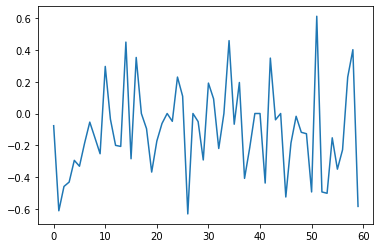

In [142]:
plt.plot(df, label = 'comp_score')
plt.show()

In [143]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(df)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [144]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [145]:
num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03726
Epoch: 100, loss: 0.03331
Epoch: 200, loss: 0.02538
Epoch: 300, loss: 0.01774
Epoch: 400, loss: 0.01239
Epoch: 500, loss: 0.01043
Epoch: 600, loss: 0.00953
Epoch: 700, loss: 0.00831
Epoch: 800, loss: 0.00759
Epoch: 900, loss: 0.00693
Epoch: 1000, loss: 0.00648
Epoch: 1100, loss: 0.00614
Epoch: 1200, loss: 0.00588
Epoch: 1300, loss: 0.00618
Epoch: 1400, loss: 0.00555
Epoch: 1500, loss: 0.00540
Epoch: 1600, loss: 0.00531
Epoch: 1700, loss: 0.00518
Epoch: 1800, loss: 0.00525
Epoch: 1900, loss: 0.00505
Epoch: 2000, loss: 0.00495
Epoch: 2100, loss: 0.00492
Epoch: 2200, loss: 0.00488
Epoch: 2300, loss: 0.00476
Epoch: 2400, loss: 0.00471
Epoch: 2500, loss: 0.00466
Epoch: 2600, loss: 0.00477
Epoch: 2700, loss: 0.00459
Epoch: 2800, loss: 0.00453
Epoch: 2900, loss: 0.00450
Epoch: 3000, loss: 0.00447
Epoch: 3100, loss: 0.00442
Epoch: 3200, loss: 0.00442
Epoch: 3300, loss: 0.00437
Epoch: 3400, loss: 0.00438
Epoch: 3500, loss: 0.00430
Epoch: 3600, loss: 0.00429
Epoch: 3700, 

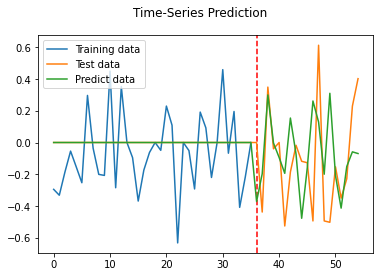

In [146]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()
dataY_training_plot = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
dataY_training_plot = sc.inverse_transform(dataY_training_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_training_plot,label='Training data')
plt.plot(np.append(np.zeros(int(len(y) * 0.67)),dataY_plot),label='Test data')
plt.plot(np.append(np.zeros(int(len(y) * 0.67)),data_predict),label='Predict data')
plt.legend(loc="upper left")
plt.suptitle('Time-Series Prediction')
plt.show()

In [147]:
FinalDate = pd.to_datetime(LastDate) + timedelta(seconds=data_predict.size-1)

In [148]:
dftest = pd.date_range(LastDate, FinalDate, freq='1s')

In [149]:
forecast_df = pd.DataFrame(data_predict, index=dftest, columns=['Forecast'])
forecast_df["Forecast"]

2021-10-18 18:15:31   -0.371552
2021-10-18 18:15:32   -0.197021
2021-10-18 18:15:33    0.299392
2021-10-18 18:15:34   -0.003099
2021-10-18 18:15:35   -0.094260
2021-10-18 18:15:36   -0.194112
2021-10-18 18:15:37    0.154064
2021-10-18 18:15:38   -0.072710
2021-10-18 18:15:39   -0.477112
2021-10-18 18:15:40   -0.157748
2021-10-18 18:15:41    0.261362
2021-10-18 18:15:42    0.129261
2021-10-18 18:15:43   -0.199671
2021-10-18 18:15:44    0.309846
2021-10-18 18:15:45   -0.208256
2021-10-18 18:15:46   -0.413194
2021-10-18 18:15:47   -0.150966
2021-10-18 18:15:48   -0.058779
2021-10-18 18:15:49   -0.069430
Freq: S, Name: Forecast, dtype: float32

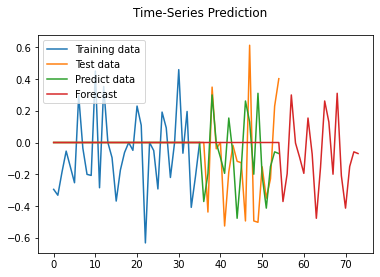

In [150]:
plt.plot(dataY_training_plot,label='Training data')
plt.plot(np.append(np.zeros(int(len(y) * 0.67)),dataY_plot),label='Test data')
plt.plot(np.append(np.zeros(int(len(y) * 0.67)),data_predict),label='Predict data')
plt.plot(np.append(np.zeros(int(len(y))),forecast_df["Forecast"]),label='Forecast')
plt.legend(loc="upper left")
plt.suptitle('Time-Series Prediction')
plt.show()